In [1]:

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
from time import time as ti
from matplotlib import cm
from tqdm import tqdm

In [2]:
def macroscopic(fin, nx, ny, v):
    rho = np.sum(fin,axis=0)
    u = np.zeros((2,nx,ny))
    for i in range(9):
        u[0,:,:] += v[i,0]*fin[i,:,:]
        u[1,:,:] += v[i,1]*fin[i,:,:]
    u /= rho
    return rho, u

In [3]:

def equilibrium(rho, u, v, t, nx, ny):
    usqr = (3/2)*(u[0]**2+u[1]**2)
    feq = np.zeros((9,nx,ny))
    for i in range(9):
        cu = 3*(v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i]*(1+cu+0.5*cu**2-usqr)
    return feq

In [4]:
def obstacle_fun(cx, cy, r):
    def inner(x, y):
        return (x-cx)**2+(y-cy)**2<r**2
    return inner


In [5]:

def inivel( uLB, ly):
    def inner(d,x,y):
        return (1-d) * uLB * (1+1e-4*np.sin(y/ly*2*np.pi))
    return inner

In [6]:

Re = 50.0                  # Reynolds number
#------------------------------------------------------------------------------
maxIter = 30000
nx,ny = 720,340             # Domain dimensions
ly = ny-1
uLB = 0.04                  # Inlet velocity NON PHYSICAL??
cx,cy,r = nx//4,ny//2,ny/9  # cylinder coordinates and radius (as integers)
nulb = uLB*r/Re             # Viscosity
omega = 1 / (3*nulb+0.5)    # Relaxation parameter

# lattice velocities
v = np.array([
            [1,1],
            [1,0],
            [1,-1],
            [0,1],
            [0,0],
            [0,-1],
            [-1,1],
            [-1,0],
            [-1,-1]
            ])

# weights
t = np.array([
            1/36,
            1/9,
            1/36,
            1/9,
            4/9,
            1/9,
            1/36,
            1/9,
            1/36
            ])

col_0 = np.array([0,1,2])
col_1 = np.array([3,4,5])
col_2 = np.array([6,7,8])

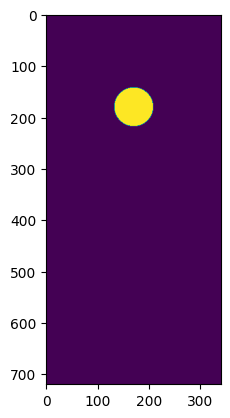

In [7]:
# instantiate the cylindrical obstacle
obstacle = np.fromfunction(obstacle_fun(cx,cy,r),(nx, ny))
if True:
  plt.imshow(obstacle)

# initial velocity profile
vel = np.fromfunction(inivel(uLB,ly),(2,nx,ny))

# initialize fin to equilibirum (rho = 1)
fin = equilibrium(1,vel,v,t,nx,ny)


100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [20:10<00:00, 24.78it/s]


time to execute =  1210.7221174240112


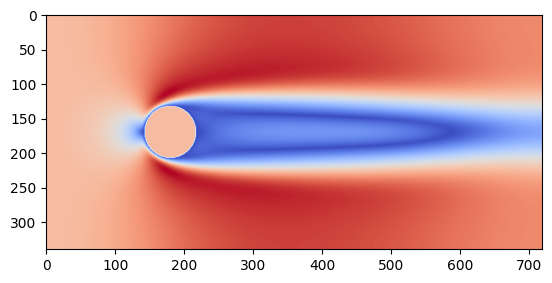

In [8]:

#==============================================================================
#   Time-Stepping
#==============================================================================
t0 = ti()
for time in tqdm(range(maxIter)):
    # outflow boundary condition (right side) NEUMANN BC! No gradient
    fin[col_2,-1,:] = fin[col_2,-2,:]

    # compute macroscopic variables
    rho,u = macroscopic(fin,nx,ny,v)

    # inlet boundary condition (left wall)
    u[:,0,:] = vel[:,0,:]
    rho[0,:] = 1/(1-u[0,0,:])*( np.sum(fin[col_1,0,:], axis = 0)+
                                2*np.sum(fin[col_2,0,:], axis = 0))

    feq = equilibrium(rho,u,v,t,nx,ny)
    fin[col_0,0,:] = feq[col_0,0,:] + fin[col_2,0,:]-feq[col_2,0,:]

    # Collide
    fout = fin - omega*(fin-feq)

    # bounceback
    for i in range(9):
        fout[i,obstacle] = fin[8-i,obstacle]

    # stream
    for i in range(9):
        # be careful with this -> numpy.roll cycles through an array by an axis
        # and the last element becomes the first. this implements a periodic
        # boundary in a very compact syntax, but needs to be reworked for other
        # implementations
        fin[i,:,:] = np.roll(
                          np.roll(
                                fout[i,:,:], v[i,0], axis = 0
                               ),
                          v[i,1], axis = 1
                          )

    # Output an image every 100 iterations
    if (time%100 == 0):
        plt.clf()
        plt.imshow(np.sqrt(u[0]**2+u[1]**2).T, cmap = cm.coolwarm)
        plt.savefig("./serialTest2/vel{0:03d}.png".format(time//100))
tf = ti() - t0
print("time to execute = ",tf)